In [12]:
import sys
sys.path.append('./packages')

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageColor
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
owid_covid_data = pd.read_csv('owid-covid-data-reduce.csv')
countries_coordinate = pd.read_csv('countries_codes_and_coordinates.csv')

In [25]:
owid_covid_data.head()
owid_covid_data = owid_covid_data[owid_covid_data['continent'].notna()]

colors6 = ['#FD0100','#F76915','#EEDE04','#A0D636','#2FA236','#333ED4']

In [26]:
for col in countries_coordinate.columns:
       countries_coordinate[col] = countries_coordinate[col].str.strip(' \"')

countries_coordinate = countries_coordinate.astype({'Latitude (average)': float,'Longitude (average)':float})



countries_coordinate.set_index('Alpha-3 code',inplace=True)

countries_coordinate.head()

,Country,Alpha-2 code,Numeric code,Latitude (average),Longitude (average)
Alpha-3 code,,,,,
AFG,Afghanistan,AF,4,33.0000,65.0
ALB,Albania,AL,8,41.0000,20.0
DZA,Algeria,DZ,12,28.0000,3.0
ASM,American Samoa,AS,16,-14.3333,-170.0
AND,Andorra,AD,20,42.5000,1.6


# PEOPLE FULL VACCINETED PER HUNDRED 

In [29]:
f = open('countriesgeo.json')

world_geo = json.load(f)

people_group_vaccinated = owid_covid_data[['iso_code','people_fully_vaccinated_per_hundred']].groupby('iso_code').max()

people_group_vaccinated.reset_index(inplace=True)



fig = px.choropleth_mapbox(people_group_vaccinated, geojson=world_geo, locations='iso_code', color='people_fully_vaccinated_per_hundred',
                           color_continuous_scale="Viridis",
                           range_color=(0, people_group_vaccinated['people_fully_vaccinated_per_hundred'].max()),
                           mapbox_style="carto-positron",
                           zoom= 0.6, center = {"lat": -10, "lon": -10},
                           featureidkey="properties.ISO_A3",
                           opacity=0.5,
                           labels={'people_fully_vaccinated_per_hundred':'people full vaccinated per 100'}
                          )
fig.update_layout(  margin={"r":0,"t":40,"l":0,"b":0},
                     title=dict(text = 'Set me title !'),height=550,width=850)
fig.show()


NameError: name 'countriesgeo' is not defined

# TOP 5 AREA HAVE BEST VACCINATIONS PERCENT AT 2/11/2021

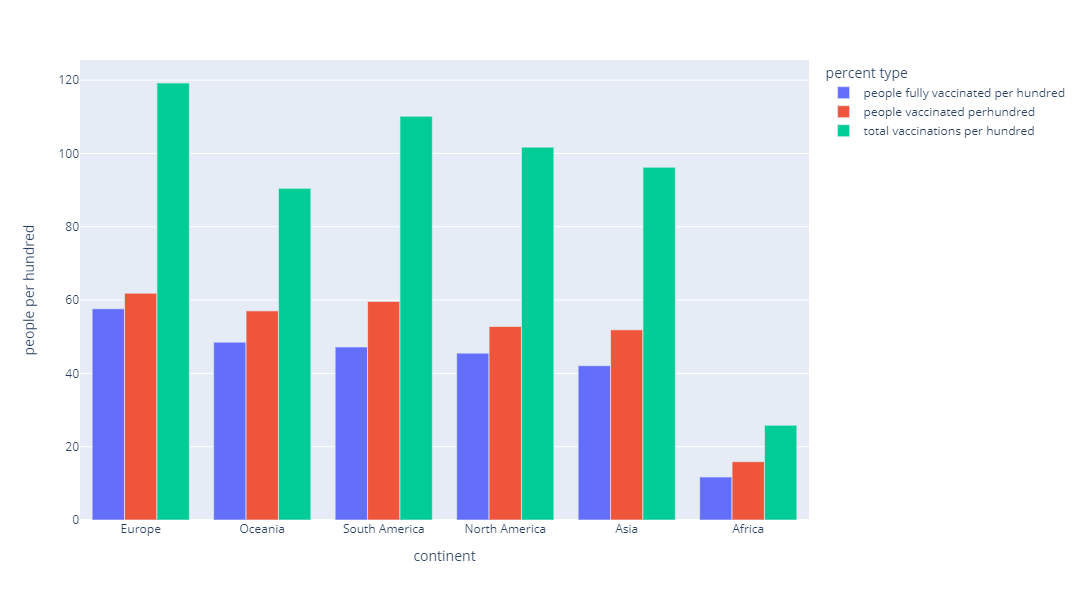

In [17]:
# at 2/11/2021

# lấy max trong nước và lấy trung bình trong châu lục 2 lần group
vaccinated   = owid_covid_data[['continent','location','people_fully_vaccinated_per_hundred','people_vaccinated_per_hundred','total_vaccinations_per_hundred']].groupby('location').max(
).groupby('continent').mean()

top5vaccinated = vaccinated.sort_values('people_fully_vaccinated_per_hundred',ascending=False)

top5vaccinated.reset_index(inplace=True)



#doi ten cot
top5vaccinated.rename(columns={
    'people_fully_vaccinated_per_hundred': 'people fully vaccinated per hundred',
    'people_vaccinated_per_hundred': 'people vaccinated perhundred',
    'total_vaccinations_per_hundred' : 'total vaccinations per hundred'
},inplace=True)


top5vaccinated_sns = pd.melt(top5vaccinated,id_vars=['continent'],value_vars=['people fully vaccinated per hundred','people vaccinated perhundred','total vaccinations per hundred']
,var_name='percent type',value_name='people per hundred')



fig = px.bar(top5vaccinated_sns, x="continent", y="people per hundred",
             color='percent type',barmode='group',
             height=600,width=750)
fig.show()


# TIME LINE OF VACCINATED 

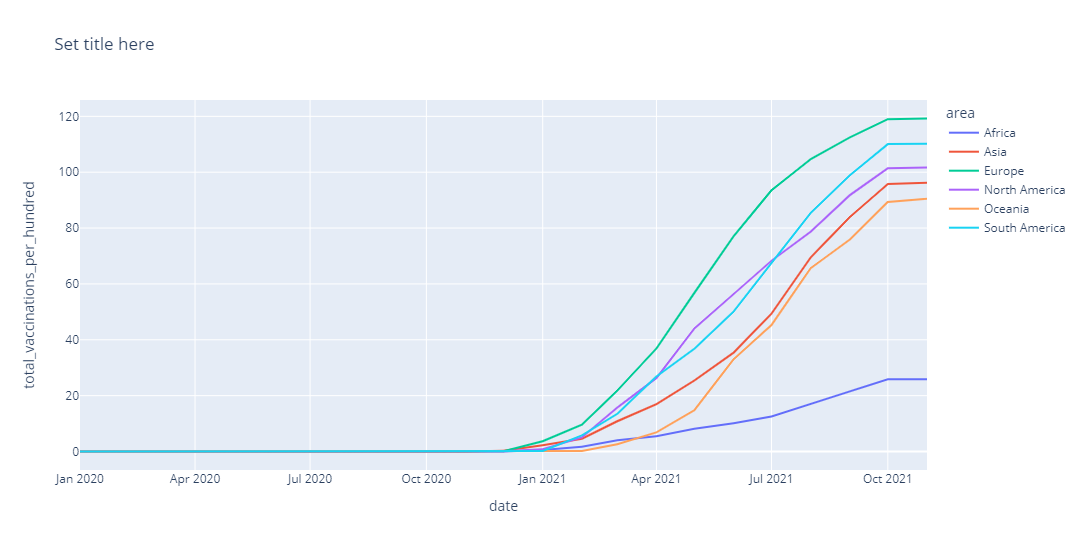

In [18]:
owid_covid_data['date'] = pd.to_datetime(owid_covid_data['date'])

area = owid_covid_data['continent'].unique()

container = []
for er in area:
     df_erea = owid_covid_data[owid_covid_data['continent'] == er]
     df_erea = df_erea[['date','total_vaccinations_per_hundred']].groupby('date').mean()
     df_erea['area'] = er
     df_erea.reset_index(inplace=True)
     container.append(df_erea)

area_time_sr = pd.concat(container,axis=0)

area_time_sr['date'] =  area_time_sr['date'].dt.to_period('M')

#max it  mean least 
area_time_sr = area_time_sr.groupby(['date','area']).max() 

area_time_sr.reset_index(inplace=True)

area_time_sr['date'] = area_time_sr['date'].astype(str)


fig = px.line(area_time_sr, x="date", y="total_vaccinations_per_hundred", color='area',height=550,width=700
,title='Set title here')
fig.show()


# AREA PROPERTIES ABILITY COMPARE


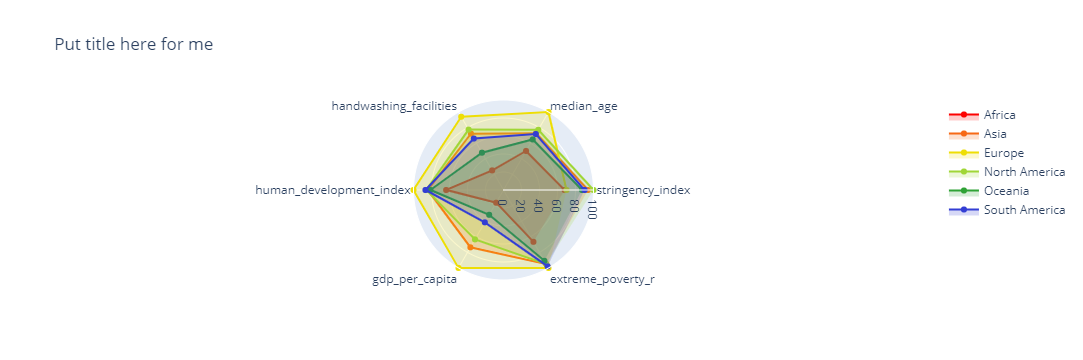

In [19]:
#TODO: 5 properties to compare 
# stringency_index
# median_age
# 1 -  extreme_poverty (we need good properties)
# handwashing_facilities
# human_development_index
# gdp_per_capita

Ability5_base_location = owid_covid_data[['continent','date','location','stringency_index','median_age','extreme_poverty','handwashing_facilities'
,'human_development_index','gdp_per_capita']].groupby('location').last()



# phần bù của tỉ lệ nghèo đói
Ability5_base_location['extreme_poverty_r'] = 100 - Ability5_base_location['extreme_poverty']
Ability5_base_location.drop(columns=['extreme_poverty'],inplace=True)


Ability5_base_area = Ability5_base_location.groupby('continent').mean()


# tẻ lệ gpd trê nuocs lớn nhất
Ability5_base_area['gdp_per_capita'] *= 100 / Ability5_base_area['gdp_per_capita'].max()
Ability5_base_area['stringency_index'] *= 100 / Ability5_base_area['stringency_index'].max()
Ability5_base_area['human_development_index'] *= 100 / Ability5_base_area['human_development_index'].max()
Ability5_base_area['extreme_poverty_r'] *= 100 / Ability5_base_area['extreme_poverty_r'].max()
Ability5_base_area['median_age'] *= 100 / Ability5_base_area['median_age'].max()
# #  --------------------------------------------------------------------

figgo = go.Figure()

idc = 0

for er in Ability5_base_area.index:
      record = Ability5_base_area.loc[er]
      det = record.tolist()
      aColor = colors6[idc]
      r,g,b = ImageColor.getcolor(aColor, "RGB")
      figgo.add_trace(go.Scatterpolar(
      r= det,
      theta=Ability5_base_area.columns,
      line = dict(color= aColor),
      fill='toself',
      fillcolor = "rgba({r}, {g}, {b}, 0.2)".format(r=r,g=g,b=b),
      name=er,
      ))
      idc+=1

figgo.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[0, 100]
    )),
  showlegend=True,
  title= dict(text='Put title here for me'),
  width=600
)

figgo.show()



# SHARE POPULATION IN CASE

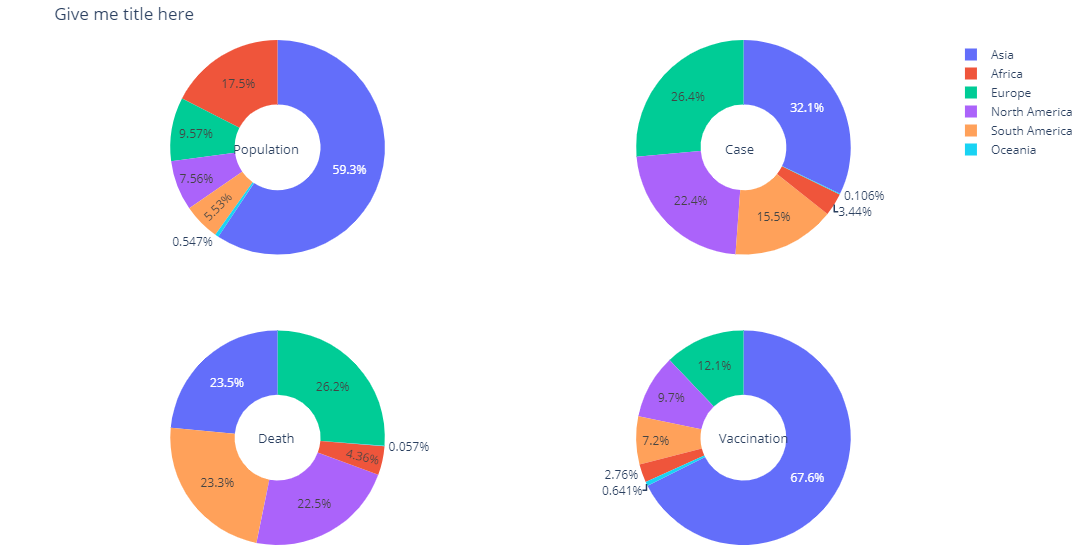

In [20]:



fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'}, {'type':'domain'}]])


c4date = owid_covid_data[['continent','location','population','total_cases','total_deaths','total_vaccinations']].groupby('location').last().groupby('continent').sum()


labels = c4date.index

fig.add_trace(go.Pie(labels=labels, values=c4date.loc[c4date.index,'population'], name="Share Population"),
              1, 1)
fig.add_trace(go.Pie(labels=labels, values=c4date.loc[c4date.index,'total_cases'].tolist(), name="Share Cases"),
              1, 2)
fig.add_trace(go.Pie(labels=labels, values=c4date.loc[c4date.index,'total_deaths'].tolist(), name="Share Deaths"),
              2, 1)
fig.add_trace(go.Pie(labels=labels, values=c4date.loc[c4date.index,'total_vaccinations'].tolist(), name="Share Vaccinations"),
              2, 2)        

fig.update_traces(hole=.4, hoverinfo="label+percent+name")

fig.update_layout(
    title_text="Give me title here",
    margin={"r":5,"t":40,"l":5,"b":5},
    height= 550,
    width = 800,
    # Add annotations in the center of the donut pies.
    annotations=[dict(text='Population', x= 0.17, y=0.805, font_size=13, showarrow=False),
                 dict(text='Case', x=0.79, y=0.805, font_size=13, showarrow=False),
                 dict(text='Death',x=0.2, y= 0.19, font_size=13, showarrow=False),
                 dict(text='Vaccination', x=0.83, y= 0.19, font_size=13, showarrow=False)
                 ])
fig.show()
         

# RELATION BETWEEN VACCINATION AND NEW CASE ,NEW DEATH

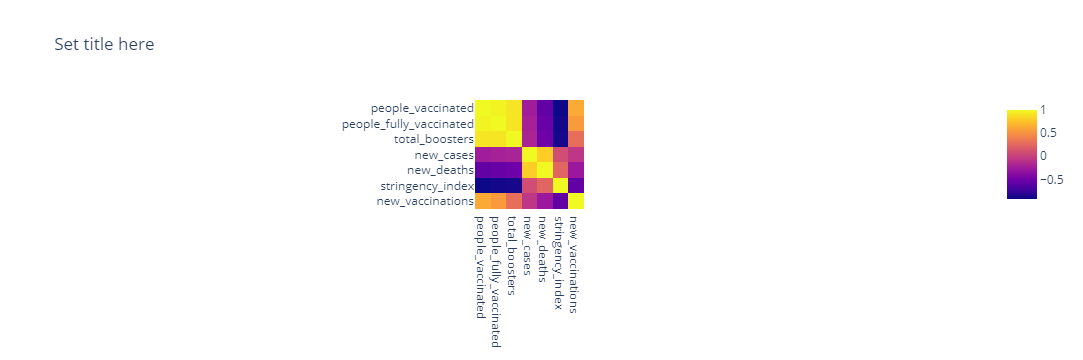

In [21]:
# HEAT MAP people_vaccinated,people_fully_vaccinated,total_boosters,NEW CASE,NEW DEATH


relation5_el = owid_covid_data[['people_vaccinated','people_fully_vaccinated','total_boosters'
,'new_cases','new_deaths','location','date','stringency_index','new_vaccinations']]

relation5_el= relation5_el.groupby('date').mean()

corr_relation5_el = relation5_el.corr()

corr_relation5_el.head()

fig = px.imshow(corr_relation5_el
, title="Set title here",width=600)

fig.show()


# BOX PLOT NEW VACCINATIONS 

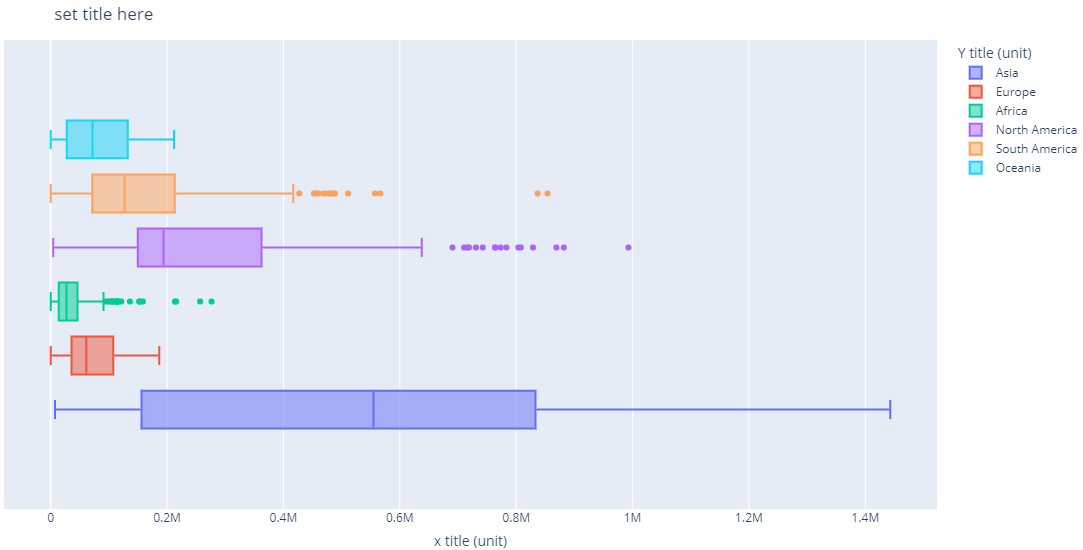

In [22]:

#use date above
erea = owid_covid_data['continent'].unique()

container = []

for er in erea:
    df_erea = owid_covid_data[owid_covid_data['continent'] == er].groupby('date').mean()
    df_erea['erea'] = er
    df_erea.reset_index(inplace=True)
    df_erea = df_erea[['erea','new_vaccinations']]
    container.append(df_erea)

boxerea_vaccine = pd.concat(container,axis=0)

fig = px.box(boxerea_vaccine, x="new_vaccinations", color="erea",height= 550,width=600,
 labels={   "new_vaccinations": "x title (unit)",
            "erea": "Y title (unit)",})

fig.update_layout(title_text='set title here',margin={"r":0,"t":40,"l":0,"b":0})
fig.show()
